In [1]:

import scipy
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
data = pd.read_csv('/Users/lijunyi/Downloads/new_model/midterm-JaydenLi0206-master/data/train.csv')

In [3]:

data.head()


,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,195370,1890228583,A3VLX5Z090RQ0V,1,2,1030838400,An Unexplained Anime Review,I was very anxious to see the Uncut version of...,2.0
1,1632470,B00BEIYSL4,AUDXDMFM49NGY,0,1,1405036800,not great.,Movie was okay...not great.,3.0
2,9771,0767809335,A3LFIA97BUU5IE,3,36,983750400,Technical problem with this DVD,"Like the Dinosaur Collector's Edition DVD, thi...",1.0
3,218855,6300215792,A1QZM75342ZQVQ,1,1,1394841600,Heeeeyyyyy LAAAAADEEE!!!!,"Come on, now..... this has to be, by far, the...",5.0
4,936225,B000B5XOZW,ANM2SCEUL3WL1,1,1,1163721600,Herzog the Great Traveler of both natural and ...,I've always been a great admirer of Herzog's o...,4.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139753 entries, 0 to 139752
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      139753 non-null  int64  
 1   ProductId               139753 non-null  object 
 2   UserId                  139753 non-null  object 
 3   HelpfulnessNumerator    139753 non-null  int64  
 4   HelpfulnessDenominator  139753 non-null  int64  
 5   Time                    139753 non-null  int64  
 6   Summary                 139752 non-null  object 
 7   Text                    139752 non-null  object 
 8   Score                   122283 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 9.6+ MB


In [5]:
data.groupby('Score').size()

Score
1.0     7361
2.0     7309
3.0    14482
4.0    27818
5.0    65313
dtype: int64

In [6]:
#show missing data
data.isnull().sum()


Id                            0
ProductId                     0
UserId                        0
HelpfulnessNumerator          0
HelpfulnessDenominator        0
Time                          0
Summary                       1
Text                          1
Score                     17470
dtype: int64

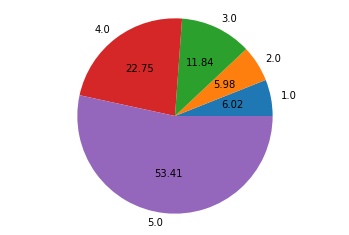

In [25]:
#show the distribution and vislualize it use pie chart using plt
data.groupby('Score').size().plot(kind='pie', autopct='%.2f')
plt.axis('equal')
plt.ylabel('')
plt.show()






# Feature Extraction

In [7]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text
data['Summary'].fillna('', inplace=True)
data['Text'].fillna('', inplace=True)
data['Summary'] = data['Summary'].apply(preprocess_text)
data['Text'] = data['Text'].apply(preprocess_text)

In [8]:
f = data.loc[data['Score'] == 5]
f = f.sample(frac=0.5)
data = pd.concat([data.loc[data['Score'] != 5], f])

# fours = data.loc[data['Score'] == 4]
# fours = fives.sample(frac=0.8)
# data = pd.concat([data.loc[data['Score'] != 4], fours])
#upsample the minority





In [9]:
data['Text'].loc[data['Text'].isna()] = ''
data['Summary'].loc[data['Summary'].isna()] = ''

In [10]:
o = OneHotEncoder(sparse=True)
IDs = o.fit_transform(data[['ProductId', 'UserId']])
IDs.shape

(107096, 84307)

In [11]:
data['Helpful'] = data['HelpfulnessNumerator']
data['Unhelpful'] = data['HelpfulnessDenominator'] - data['HelpfulnessNumerator']
scaler = StandardScaler()
data[['Helpful', 'Unhelpful', 'Time']] = scaler.fit_transform(data[['Helpful', 'Unhelpful', 'Time']])
data = data.drop(['HelpfulnessDenominator','HelpfulnessNumerator'], axis=1)

In [12]:
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know'])

In [13]:
t_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words=stop_words)
# summary_vectorizer = TfidfVectorizer(input='content', analyzer='char', stop_words='english')
s_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words=stop_words)
t= t_vectorizer.fit_transform(data['Text'])
s= s_vectorizer.fit_transform(data['Summary'])

In [15]:
numerical = scipy.sparse.csr_matrix(data[['Helpful', 'Unhelpful', 'Time']].values)

In [16]:
# X = hstack([text_matrix, summary_matrix, numerical, IDs, data['SentimentPolarity'].values.reshape(-1, 1)])
X = hstack([t, s, numerical, IDs])


In [17]:
data.head()

,Id,ProductId,UserId,Time,Summary,Text,Score,Helpful,Unhelpful
0,195370,1890228583,A3VLX5Z090RQ0V,-1.767121,an unexplained anime review,i was very anxious to see the uncut version of...,2.0,-0.127611,-0.137102
1,1632470,B00BEIYSL4,AUDXDMFM49NGY,1.131944,not great,movie was okaynot great,3.0,-0.176763,-0.137102
2,9771,0767809335,A3LFIA97BUU5IE,-2.131930,technical problem with this dvd,like the dinosaur collectors edition dvd this ...,1.0,-0.029305,4.295372
4,936225,B000B5XOZW,ANM2SCEUL3WL1,-0.737621,herzog the great traveler of both natural and ...,ive always been a great admirer of herzogs oeu...,4.0,-0.127611,-0.275617
6,1213850,B001L8YQ64,A2OFSDJB3MVQ16,-0.107739,disappointing night,saw this film recently on showtime and it was ...,2.0,-0.078458,0.278442


In [18]:
mask = data["Score"].isnull()
te = mask.to_numpy().nonzero()[0]
tr = (~ mask).to_numpy().nonzero()[0]
Xtrain = scipy.sparse.csr_matrix(X)[tr]
test_X = scipy.sparse.csr_matrix(X)[te]
Ytrain = data['Score'].loc[data['Score'].isna() == False].reset_index()['Score']
test_Y = data['Score'].loc[data['Score'].isna()].reset_index()['Score']

# Model

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
X_train, X_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size=0.1, random_state=0)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((80663, 493855), (8963, 493855), (80663,), (8963,))

In [21]:

model = lgb.LGBMRegressor()

# The 'early_stopping_rounds' is passed inside the 'callbacks' argument of fit method
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    eval_metric='rmse',
   
    callbacks=[lgb.early_stopping(30)]
    
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 15.296496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088550
[LightGBM] [Info] Number of data points in the train set: 80663, number of used features: 22736
[LightGBM] [Info] Start training from score 3.793524
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.85437	valid_0's l2: 0.729948


LGBMRegressor()

In [22]:
#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model= RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('rmse=',mean_squared_error(y_test, y_pred))


In [22]:
params = {
    'objective': 'regression', 
    'metric': 'rmse',
    'num_leaves': 300,
    'learning_rate': 0.03,
    'n_estimators': 500,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
    
    
    
}

model = lgb.LGBMRegressor(**params)

# The 'early_stopping_rounds' is passed inside the 'callbacks' argument of fit method
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    eval_metric='rmse',
   
    callbacks=[lgb.early_stopping(10)]
    
)

y_pred = model.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(y_test, y_pred) ** 0.5)



Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[438]	valid_0's rmse: 0.792914


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.03, metric='rmse', n_estimators=500,
              num_leaves=300, objective='regression', verbose=-1)

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Assuming 'X_train', 'y_train' are already defined and are the train-test splits

# Define the parameter grid to search
param_grid = {
    'num_leaves': [300,400,500],
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [100, 300, 500],
   
}

# Initialize the LGBMRegressor
model = lgb.LGBMRegressor(objective='regression', metric='rmse', verbose=-1)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the best RMSE
print("Best parameters found by grid search are:", best_params)
print("Best RMSE found by grid search is:", best_score)


RMSE on testing set =  0.7929142875996318


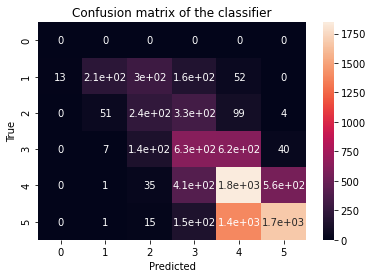

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
y_pred = model.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(y_test, y_pred) ** 0.5)
cm=confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
import pickle
with open('lgbm_model.obj', 'wb') as f:
        pickle.dump(model, f)

In [25]:
testingSet = pd.read_csv("/Users/lijunyi/Downloads/cs506-fall-2023-midterm/X_test.csv")
testingSet['Score'] = model.predict(test_X)
submission = testingSet[['Id', 'Score']]
submission.to_csv('/Users/lijunyi/Downloads/new_model/midterm-JaydenLi0206-master/data/submission.csv', index=False)